# Link prediction for NetworKit

In [58]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt

In [59]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [113]:
G = readGraph("input/jazz.graph", Format.METIS)

In [114]:
partitionedGraph = linkprediction.RandomEdgePartitioner(G).partition(0.3)
G.numberOfEdges()

2742

In [115]:
partitionedGraph[0].numberOfEdges()

1920

In [116]:
partitionedGraph[1].numberOfEdges()

822

In [117]:
katzIndex = linkprediction.KatzIndex(partitionedGraph[0])

In [118]:
dyadScorePairs = katzIndex.runAll()

In [119]:
roc = linkprediction.ROC(partitionedGraph[1], dyadScorePairs)

In [120]:
roc.generatePoints()
points = roc.getPoints()

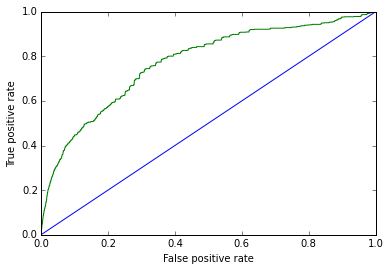

In [121]:
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1])
plt.plot(points[0], points[1])

In [122]:
roc.areaUnderCurve()

0.7715077188659567